# Nicolas Agreda - Fake News Detection using ML

## Load Datasets

In [69]:
import numpy as np
import pandas as pd

In [2]:
true = pd.read_csv('true.csv')

In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
true.shape

(21417, 4)

In [5]:
fake = pd.read_csv('fake.csv')

In [7]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.shape

(23481, 4)

> **Real News = 1**
>
> **Fake News = 0**

In [8]:
true['label'] = 1
fake['label'] = 0

In [9]:
# Use the the first 5000 data of true and fake dataset for building the model.
frames = [true.loc[:5000][:], fake.loc[:5000][:]]

In [10]:
df = pd.concat(frames)

In [51]:
df.shape # (n_rows, n_columns)

(10002, 5)

In [52]:
X = df. drop('label', axis=1)
y = df['label']

In [53]:
df = df.dropna() # drop all null values
df2 = df.copy() # create a copy dataframe to preserve original dataframe from being corrupted

In [54]:
df2.reset_index(inplace=True)
df2.head()

,index,title,text,subject,date,label
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


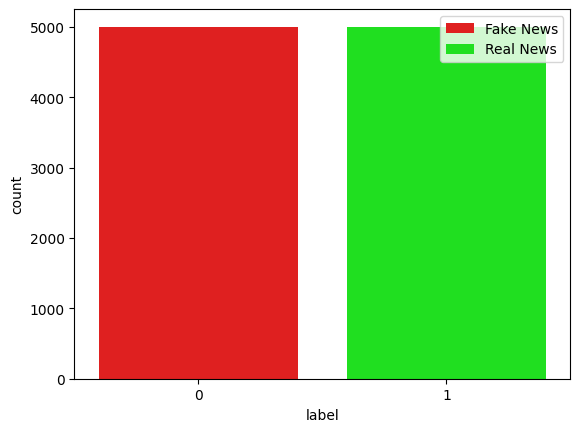

In [77]:
import seaborn as sns

# show number of Fake and Real News
colors = ['#ff0000', '#00ff00']
sns.countplot(data=df2, x='label', hue='label', palette=colors, legend=False)
plt.legend(labels=['Fake News', 'Real News'])
plt.show()

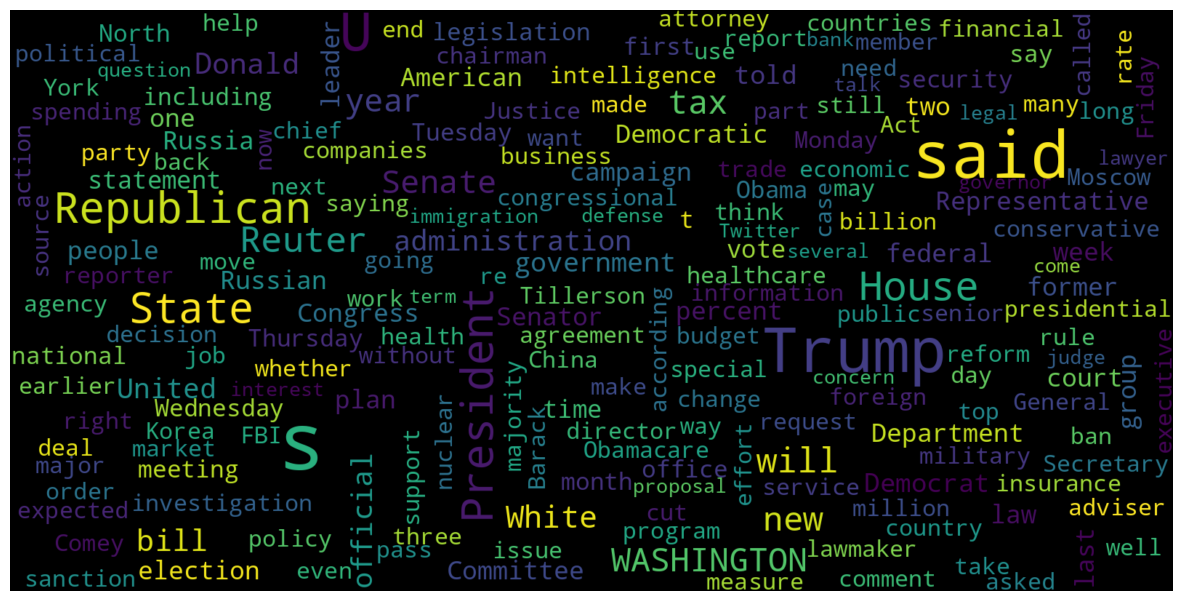

In [60]:
from wordcloud import WordCloud
# Real News
consolidated = ' '.join(
    word for word in df2['text'][df2['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

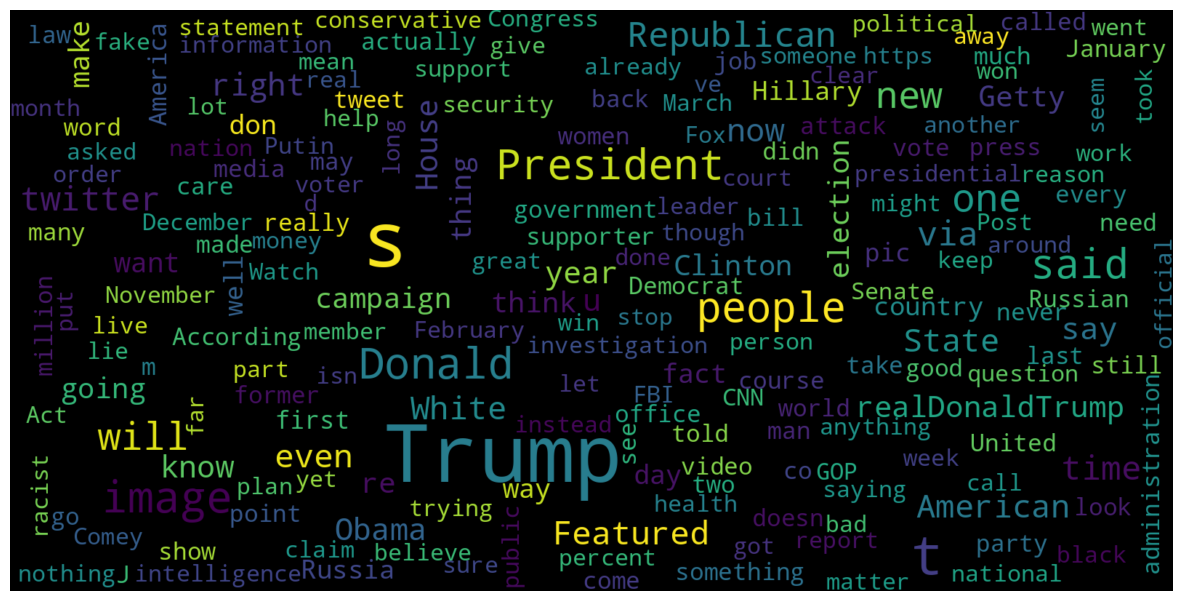

In [61]:
# Fake News
consolidated = ' '.join(
    word for word in df2['text'][df2['label'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

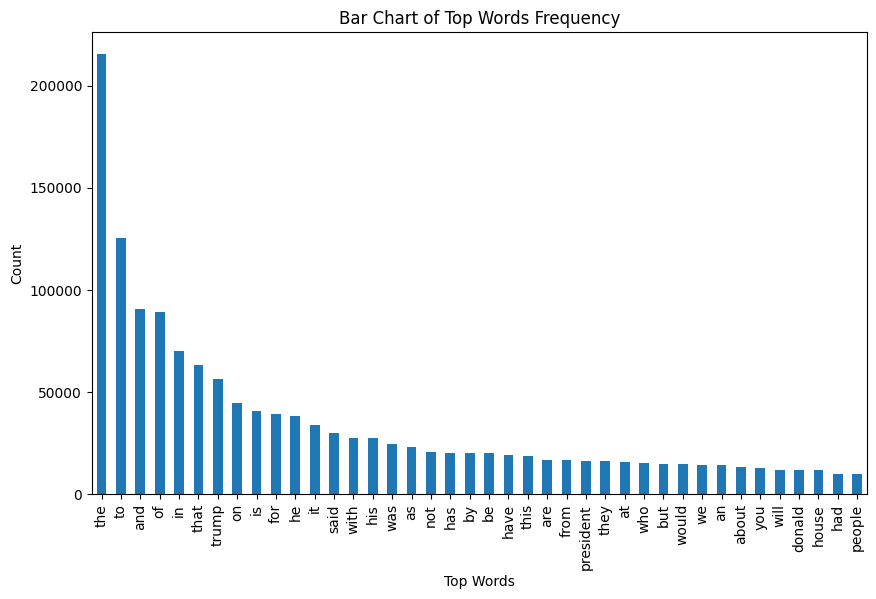

In [92]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df2['text'], 40)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)
plt.show()

## Data Preprocessing - Translate "Sentences of Words" into "Arrays of Numbers" that Machine/Computer can learn

In [15]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [16]:
import re
import nltk
nltk.download('stopwords')

corpus = []
for i in range(0, len(df2)):
    review = re.sub('[^a-zA-Z]', ' ', df2['text'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# TFidf Vectorizer - convert sentences into arrays
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

In [18]:
X = tfidf_v.fit_transform(corpus).toarray()
y = df2['label']

In [64]:
X

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
4996,Justice Department Announces It Will No Longe...,Republicans are about to lose a huge source of...,News,"August 18, 2016"
4997,WATCH: S.E. Cupp Destroys Trump Adviser’s ‘Fa...,A pawn working for Donald Trump claimed that w...,News,"August 18, 2016"
4998,WATCH: Fox Hosts Claim Hillary Has Brain Dama...,Fox News is desperate to sabotage Hillary Clin...,News,"August 18, 2016"
4999,CNN Panelist LAUGHS In Corey Lewandowski’s Fa...,As Donald Trump s campaign continues to sink d...,News,"August 18, 2016"


In [65]:
y

0       1
1       1
2       1
3       1
4       1
       ..
4996    0
4997    0
4998    0
4999    0
5000    0
Name: label, Length: 10002, dtype: int64

In [19]:
# Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model Building - Passive Agressive Classifier

In [20]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifier = PassiveAggressiveClassifier(max_iter=1000)

In [21]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.999


In [22]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


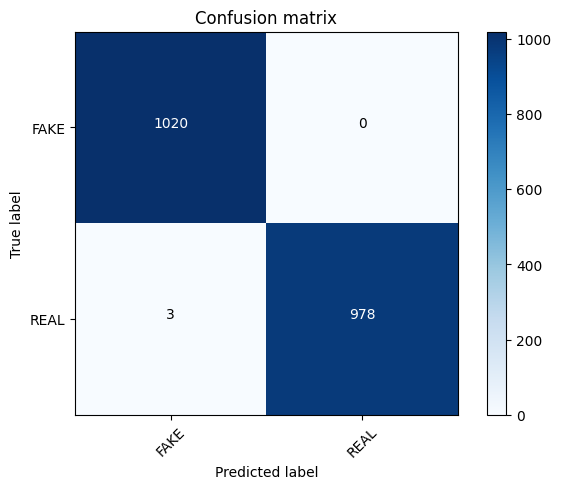

In [23]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Validate on Unseen Datapoint

In [132]:
text = fake['text'][13]
# text = """
# ‘We will operate against Hamas everywhere’: Gallant
# Israel’s defence minister has said ahead of meetings in the White House that Israel will not stop its war on Gaza.

# Yoav Gallant, according to a statement from his office, said he would stress in his meeting with US National Security Advisor Jake Sullivan: “We will operate against Hamas everywhere – including in places where we have not yet been.”

# “We will identify an alternative to Hamas, so that the IDF [Israeli army] may complete its mission,” he said. We have no moral right to stop the war while there are still hostages held in Gaza.”
# """
print(text)
def process_text(text, verbose=True):
    if verbose:
        print("Text: ", text)

    review = re.sub('[^a-zA-Z]', ' ', text)
    if verbose:
        print("Review: ", review)

    review = review.lower()
    if verbose:
        print("Review: ", review)

    review = review.split()
    if verbose:
        print("Review: ", review)

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    if verbose:
        print("Review: ", review)

    review = ' '.join(review)
    if verbose:
        print("Review: ", review)
    return review

review = process_text(text)

The media has been talking all day about Trump and the Republican Party s scam of a tax bill; as well as the sheer obsequiousness of Trump s cabinet, and then members of Congress, after their tax scam was all but passed. But the media isn t quite saying what Trump wants. They ve been doing analysis and discussion all day long rather than praising it for the grand achievement Trump believes it is. The GOP has increasingly sounded exactly like Trump when it comes to media coverage, and coverage of the tax scam is no different. Coverage of Trump in general hasn t changed.Today, Lindsey Graham went after the media for portraying Trump as a  kook,  and unfit for office (they wouldn t be doing their job if they weren t telling the truth, though). Graham said: You know what concerns me about the American press is this endless, endless attempt to label the guy as some kind of kook; not fit to be president. Jake Tapper notes that he himself has never labeled Trump that way. But then he points o

In [133]:
val = tfidf_v.transform([review]).toarray()

In [134]:
print('*'*30)
print()
print(classifier.predict(val))
print("Real News" if classifier.predict(val) == np.array([1]) else "Fake News") # 1 = true, 0 = fake
print()
print('*'*30)

******************************

[0]
Fake News

******************************


## Save model and vectorizer

In [136]:
import pickle
pickle.dump(classifier, open('detector_model.pkl', 'wb'))
pickle.dump(tfidf_v, open('vectorizer.pkl', 'wb'))

## Load model and vectorizer to predict the previous datapoint

In [137]:
loaded_model = pickle.load(open('detector_model.pkl', 'rb'))
loaded_vect = pickle.load(open('vectorizer.pkl', 'rb'))
review = process_text(text, verbose=False)
val_pkl = loaded_vect.transform([review]).toarray()
test_pred = loaded_model.predict(val_pkl)

print("*"*30)
print()
if test_pred == 0:
    print("Fake News!")
else:
    print("Real News")
print()
print("*"*30)

******************************

Fake News!

******************************


In [96]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==0.26.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.1
build==1.1.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.1
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.5
cufflinks==0.17.3
cupy-cuda12x==12.2.0
